## Exploratory Data Analysis

Initial exploration of the Student Performance dataset to understand feature distributions, detect issues, and guide preprocessing and modeling.

**Goals:**
- Inspect structure and types  
- Explore distributions and relationships  
- Identify missing values and outliers  
---

In [32]:
# Standard libraries
import sys
from pathlib import Path

# Add project root to sys.path
sys.path.append(str(Path().resolve().parent))

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

# Custom modules
from scripts.data_loader import load_raw
from scripts.saver import save_plot, save_dataset
from scripts.eda_plots import (
    plot_missing_heatmap,
    plot_numeric_distributions,
    plot_numeric_boxplots,
    plot_correlation_matrix,
    plot_countplots
)

In [33]:
# Load the dataset
df = load_raw("data-corrupted.csv")

In [34]:
# Inspect basic structure
print(f"Shape: {df.shape}")
display(df.head())

Shape: (395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,NaN,...,4,3,4,1.0,1,3,6,5,6.0,6
1,NaN,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1.0,1,3,4,5,5.0,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2.0,3,3,10,7,8.0,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1.0,1,5,2,15,14.0,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1.0,2,5,4,6,10.0,10


---

##  Missing Value Analysis

We examine the extent and distribution of missing values across features to guide imputation strategies during preprocessing.


In [35]:
# Count missing values and calculate percentages
missing_report = (
    df.isnull()
    .sum()
    .to_frame(name='Missing Count')
    .assign(Percentage=lambda x: 100 * x['Missing Count'] / len(df))
    .query('`Missing Count` > 0')
    .sort_values('Percentage', ascending=False)
    .reset_index()  # Moves index to a column
    .rename(columns={"index": "col_name"})
)

missing_report


,col_name,Missing Count,Percentage
0,Mjob,51,12.911392
1,school,31,7.848101
2,Fjob,23,5.822785
3,nursery,23,5.822785
4,paid,19,4.810127
5,traveltime,11,2.784810
6,internet,7,1.772152
7,schoolsup,3,0.759494
8,Dalc,3,0.759494
9,G2,3,0.759494


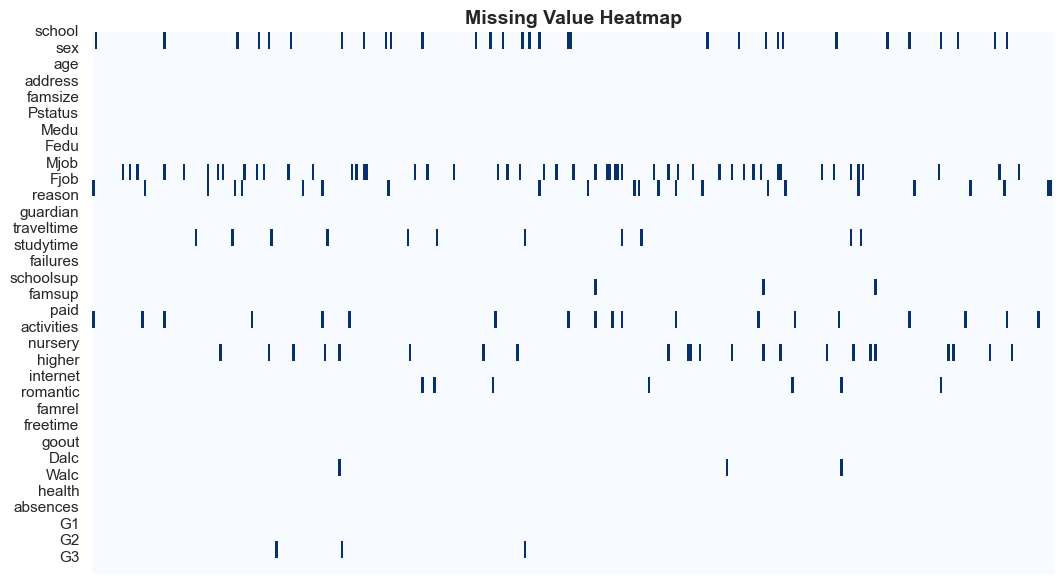

In [36]:
missing_value_heatmap = plot_missing_heatmap(df)

The most affected features by missingness include categorical variables such as `Mjob`, `school`, and `Fjob`. The overall proportion of missing data remains relatively low, making it manageable for imputation or selective row removal depending on the context.

**Next Steps:**
- Handle missing values using appropriate strategies (e.g., mode for categorical, median for numerical)
- Document imputed features for transparency and reproducibility

---

## Feature Type Overview

We categorize features into numerical and categorical to guide further analysis and preprocessing decisions.


In [37]:
# Separate columns by type
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print(f" {len(num_cols)} numerical features:\n  {', '.join(num_cols)}\n")
print(f" {len(cat_cols)} categorical features:\n  {', '.join(cat_cols)}")

 16 numerical features:
  age, Medu, Fedu, traveltime, studytime, failures, famrel, freetime, goout, Dalc, Walc, health, absences, G1, G2, G3

 17 categorical features:
  school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardian, schoolsup, famsup, paid, activities, nursery, higher, internet, romantic


### Numerical Feature Distributions

We visualize the distribution of numerical features to understand data shape, detect skewness, and spot potential outliers.


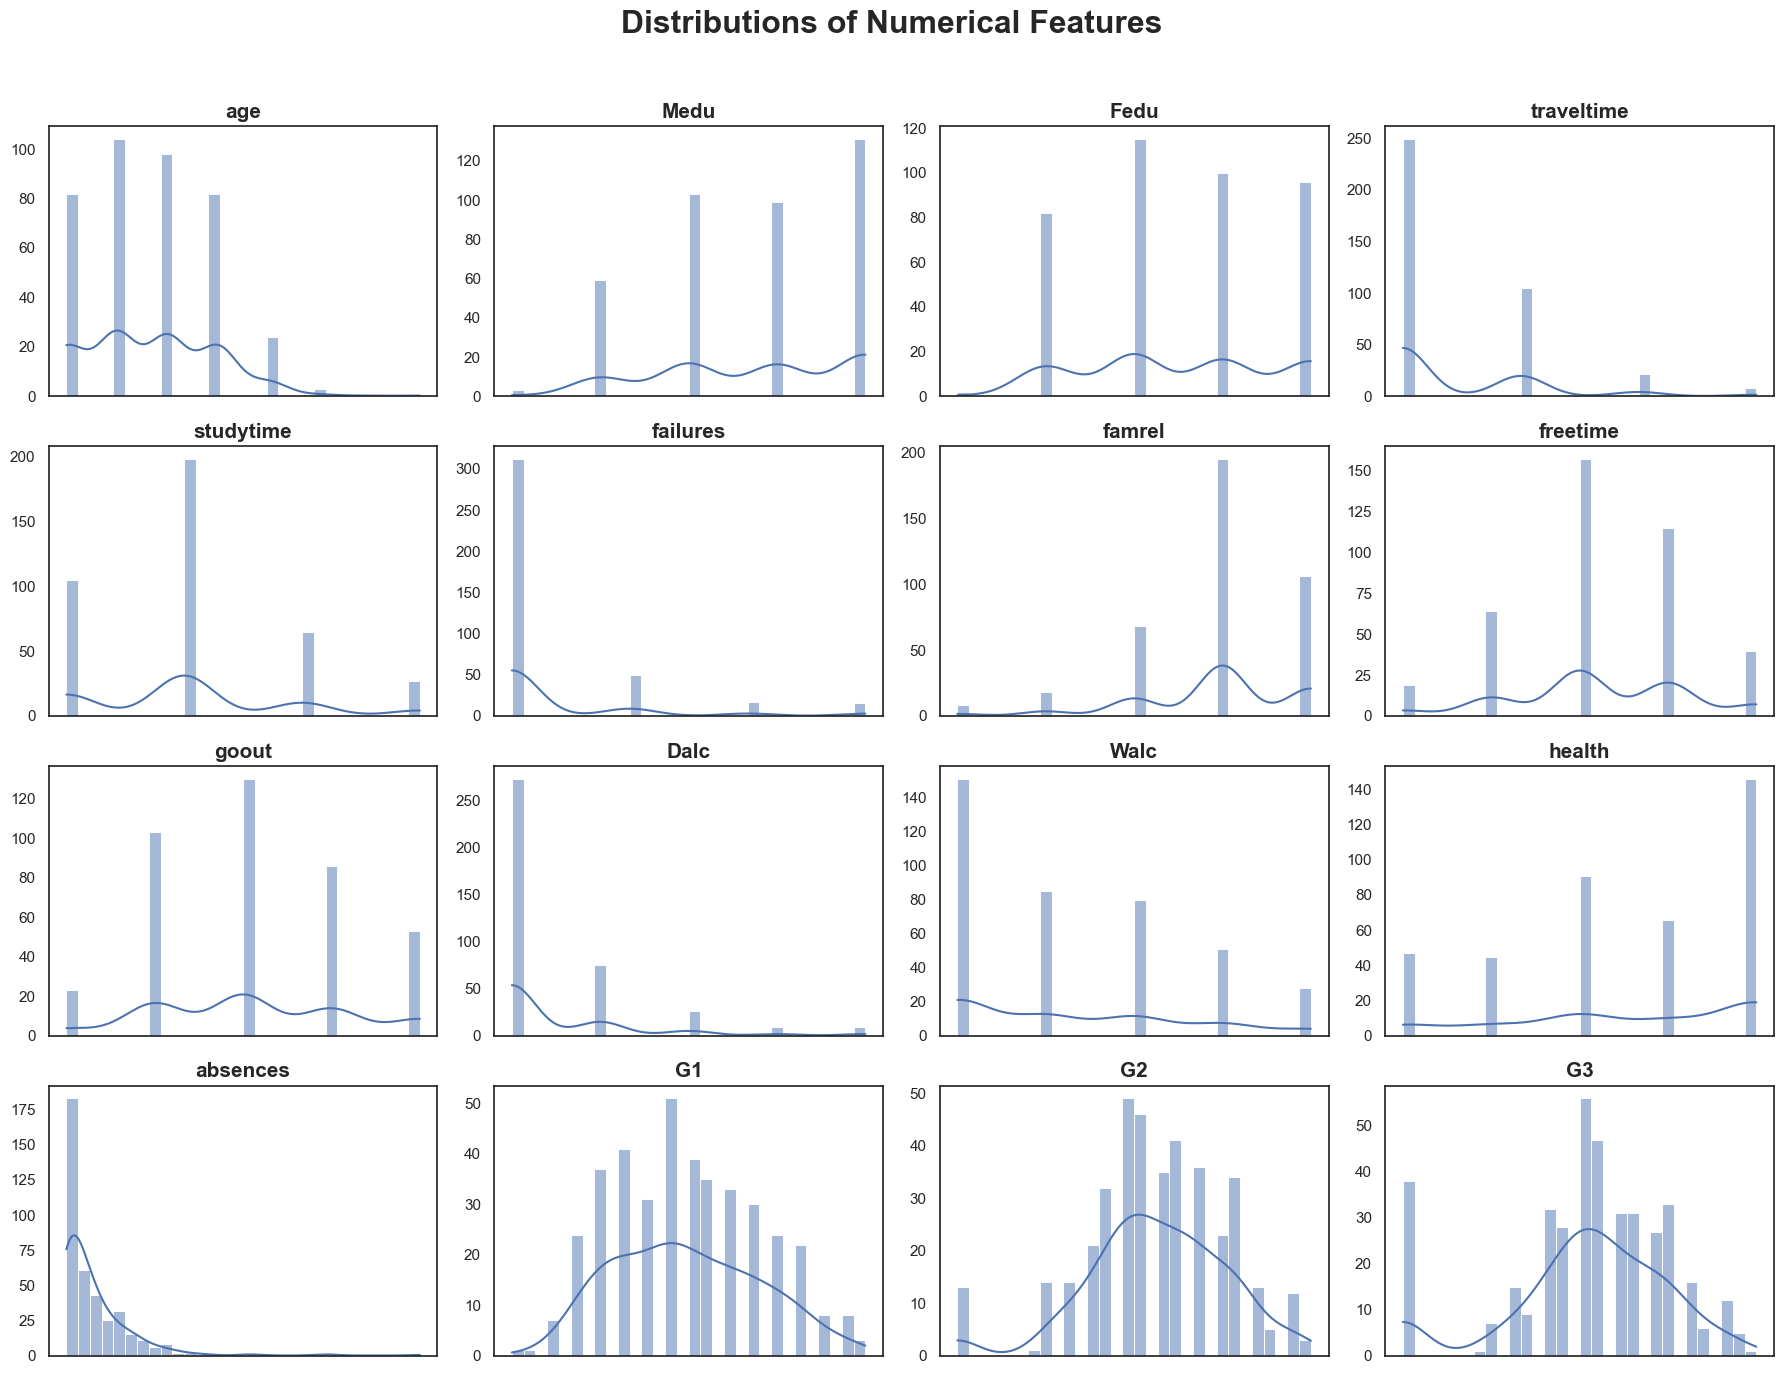

In [38]:
feature_distributions = plot_numeric_distributions(df, num_cols)

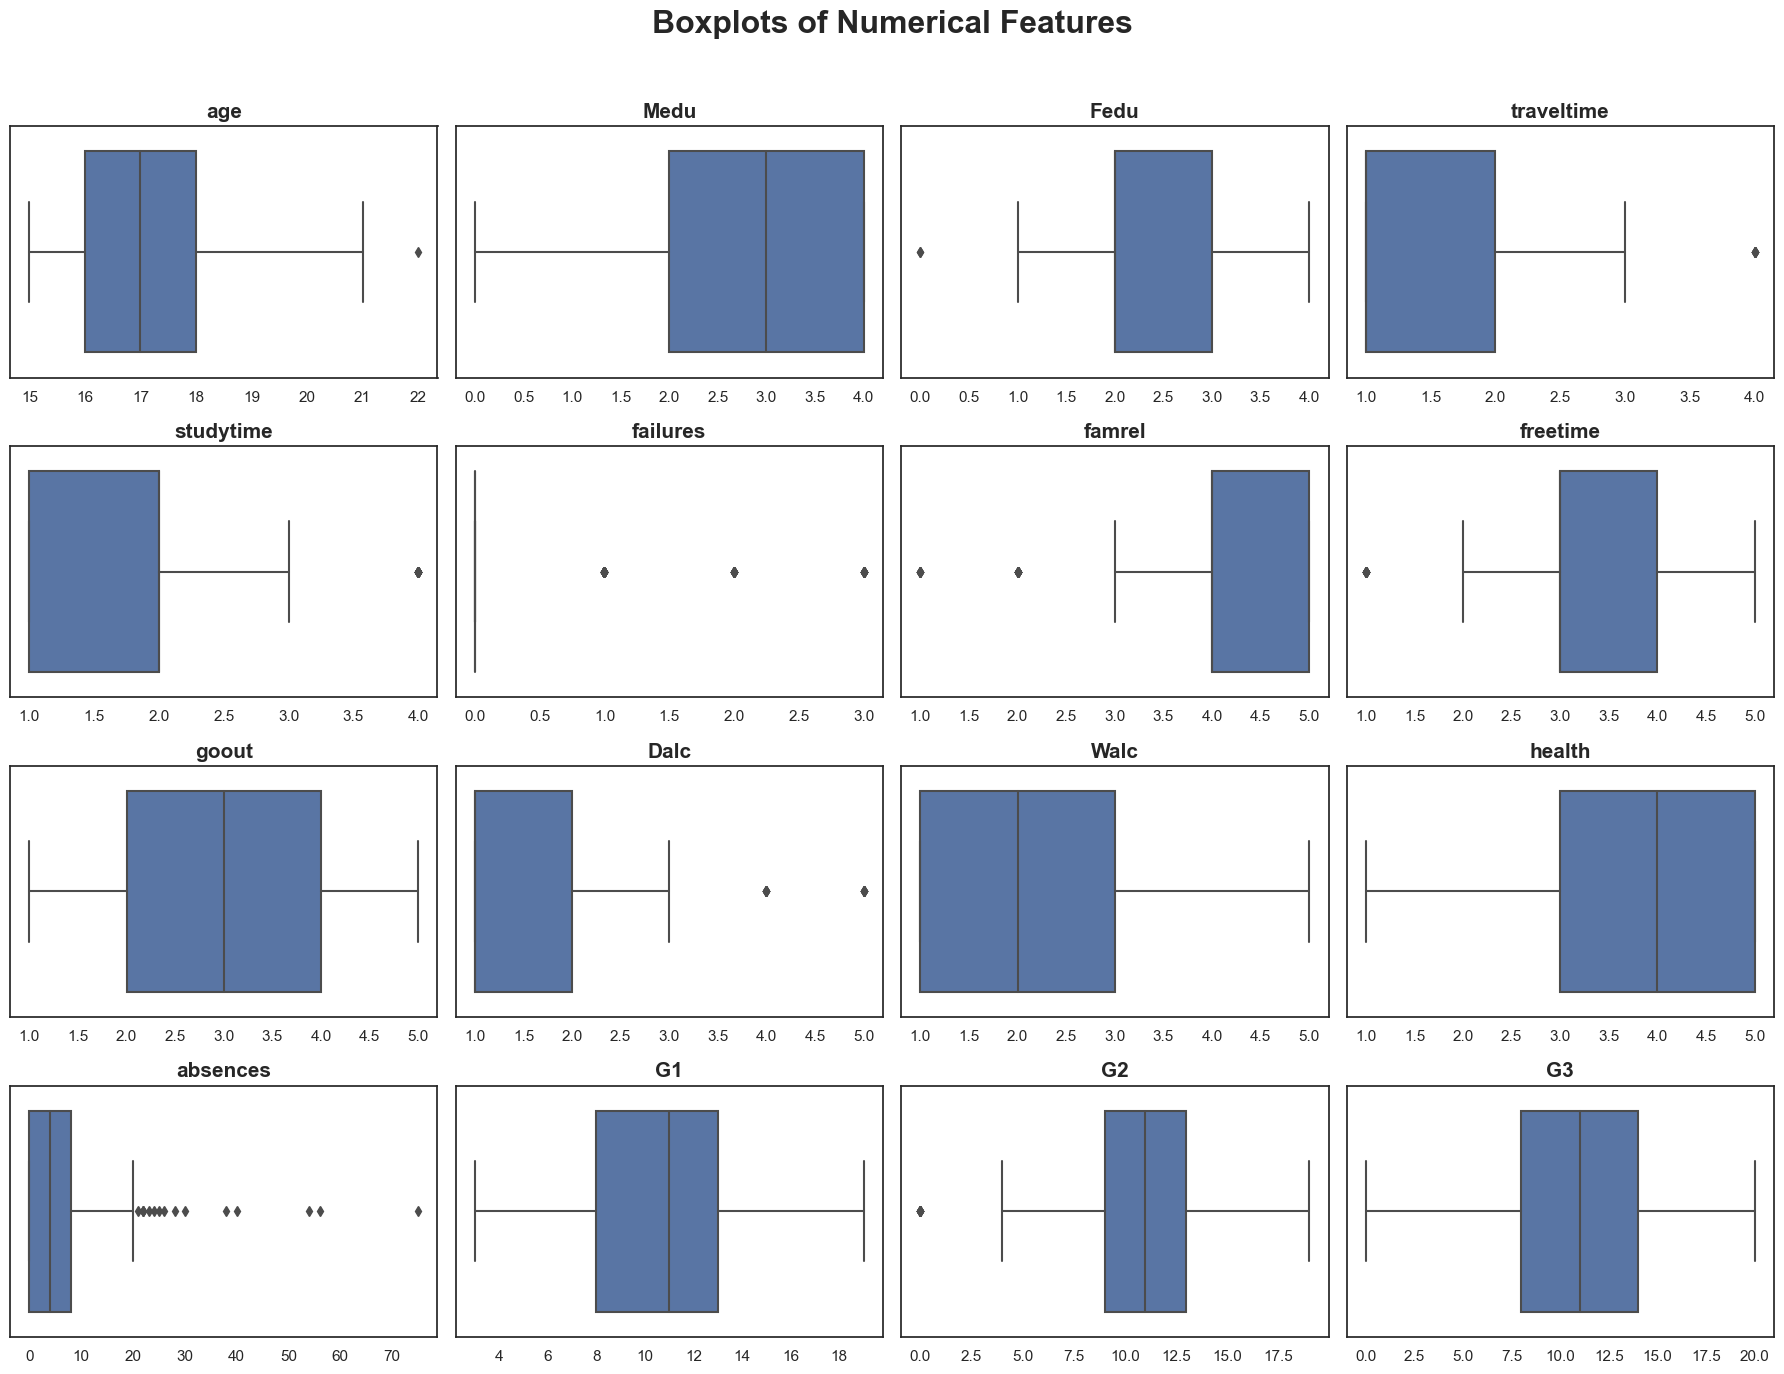

In [39]:
boxplots = plot_numeric_boxplots(df, num_cols)

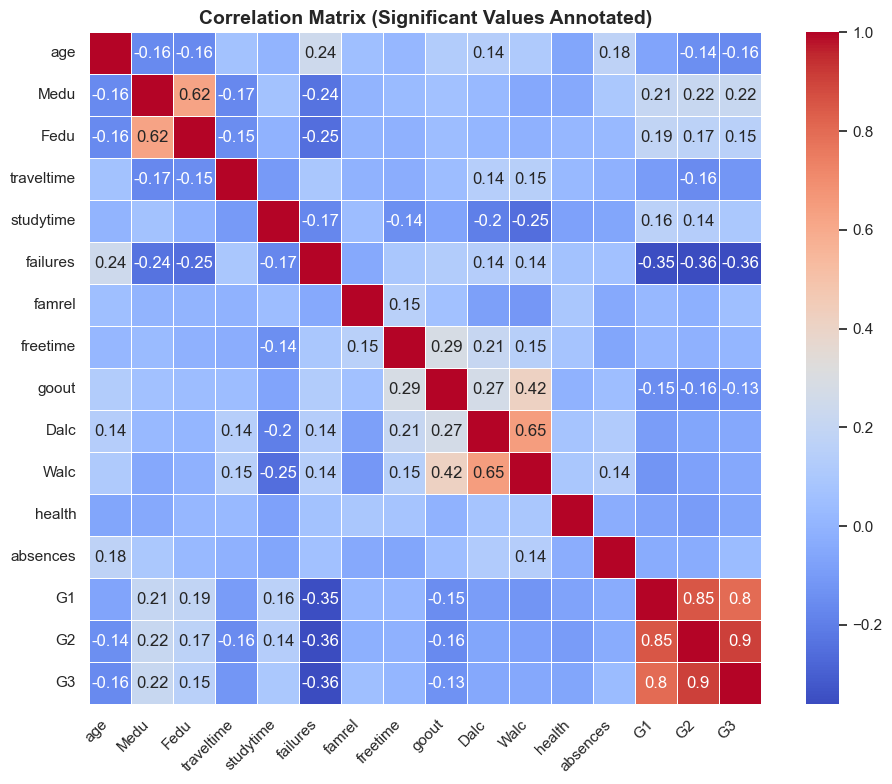

In [40]:
correlation_matrix = plot_correlation_matrix(df, num_cols)

In [41]:
# Analysing sweness
skew_summary = df[num_cols].skew().sort_values(ascending=False).to_frame(name='Skewness')
skew_summary

,Skewness
absences,3.671579
failures,2.387026
Dalc,2.178612
traveltime,1.607585
studytime,0.632142
Walc,0.611960
age,0.466270
G1,0.240613
goout,0.116502
Fedu,-0.031672



- Most features such as `age`, `G1`, `G2`, and `G3` are fairly symmetrically distributed.

- Features like `failures`, `Dalc`, and especially `absences` are strongly right-skewed, with skewness values of 2.39, 2.18, and 3.67 respectively, indicating long-tailed distributions and several outliers.

- Mild skew is also observed in `traveltime` (1.61) and `studytime` (0.63), suggesting potential benefit from transformation depending on model choice.

- Some variables (e.g., `Medu`, `Fedu`, `famrel`) have low or negative skew and may not require transformation.

- Features such as `Medu`, `Fedu`, and `traveltime` show limited variance and may need to be evaluated for informativeness.

- Correlation analysis reveals strong positive relationships among `G1`, `G2`, and `G3` (ρ ≈ 0.8–0.9), which confirms grade progression dependency.

- We also observe moderate, statistically significant associations such as `Medu`–`Fedu` and `Walc`–`Dalc`, while most other features show weak or no linear relationships.

These findings will guide outlier treatment, transformation strategies, and feature selection in future stages.

---

### Categorical Feature Exploration

We analyze the structure of categorical features by first inspecting their number of unique values, which helps distinguish binary, ordinal, and nominal variables. This step also highlights low-variance features and potential high-cardinality issues.

Next, we visualize category frequencies using count plots to:
- Understand the distribution of each categorical variable
- Detect class imbalances or underrepresented categories

These insights will guide feature encoding choices and highlight potential data quality concerns.


In [42]:
# Create summary of unique value counts and actual unique items
unique_summary = pd.DataFrame({
    'Unique Values': df[cat_cols].nunique(dropna=False),
    'Categories': [df[col].dropna().unique().tolist() for col in cat_cols]
}).sort_values(by='Unique Values', ascending=False)

unique_summary

,Unique Values,Categories
Mjob,6,"[at_home, health, other, services, teacher]"
Fjob,6,"[other, services, teacher, health, at_home]"
reason,4,"[course, other, home, reputation]"
school,3,"[GP, MS]"
schoolsup,3,"[yes, no]"
internet,3,"[no, yes]"
nursery,3,"[yes, no]"
paid,3,"[no, yes]"
guardian,3,"[mother, father, other]"
sex,2,"[F, M]"


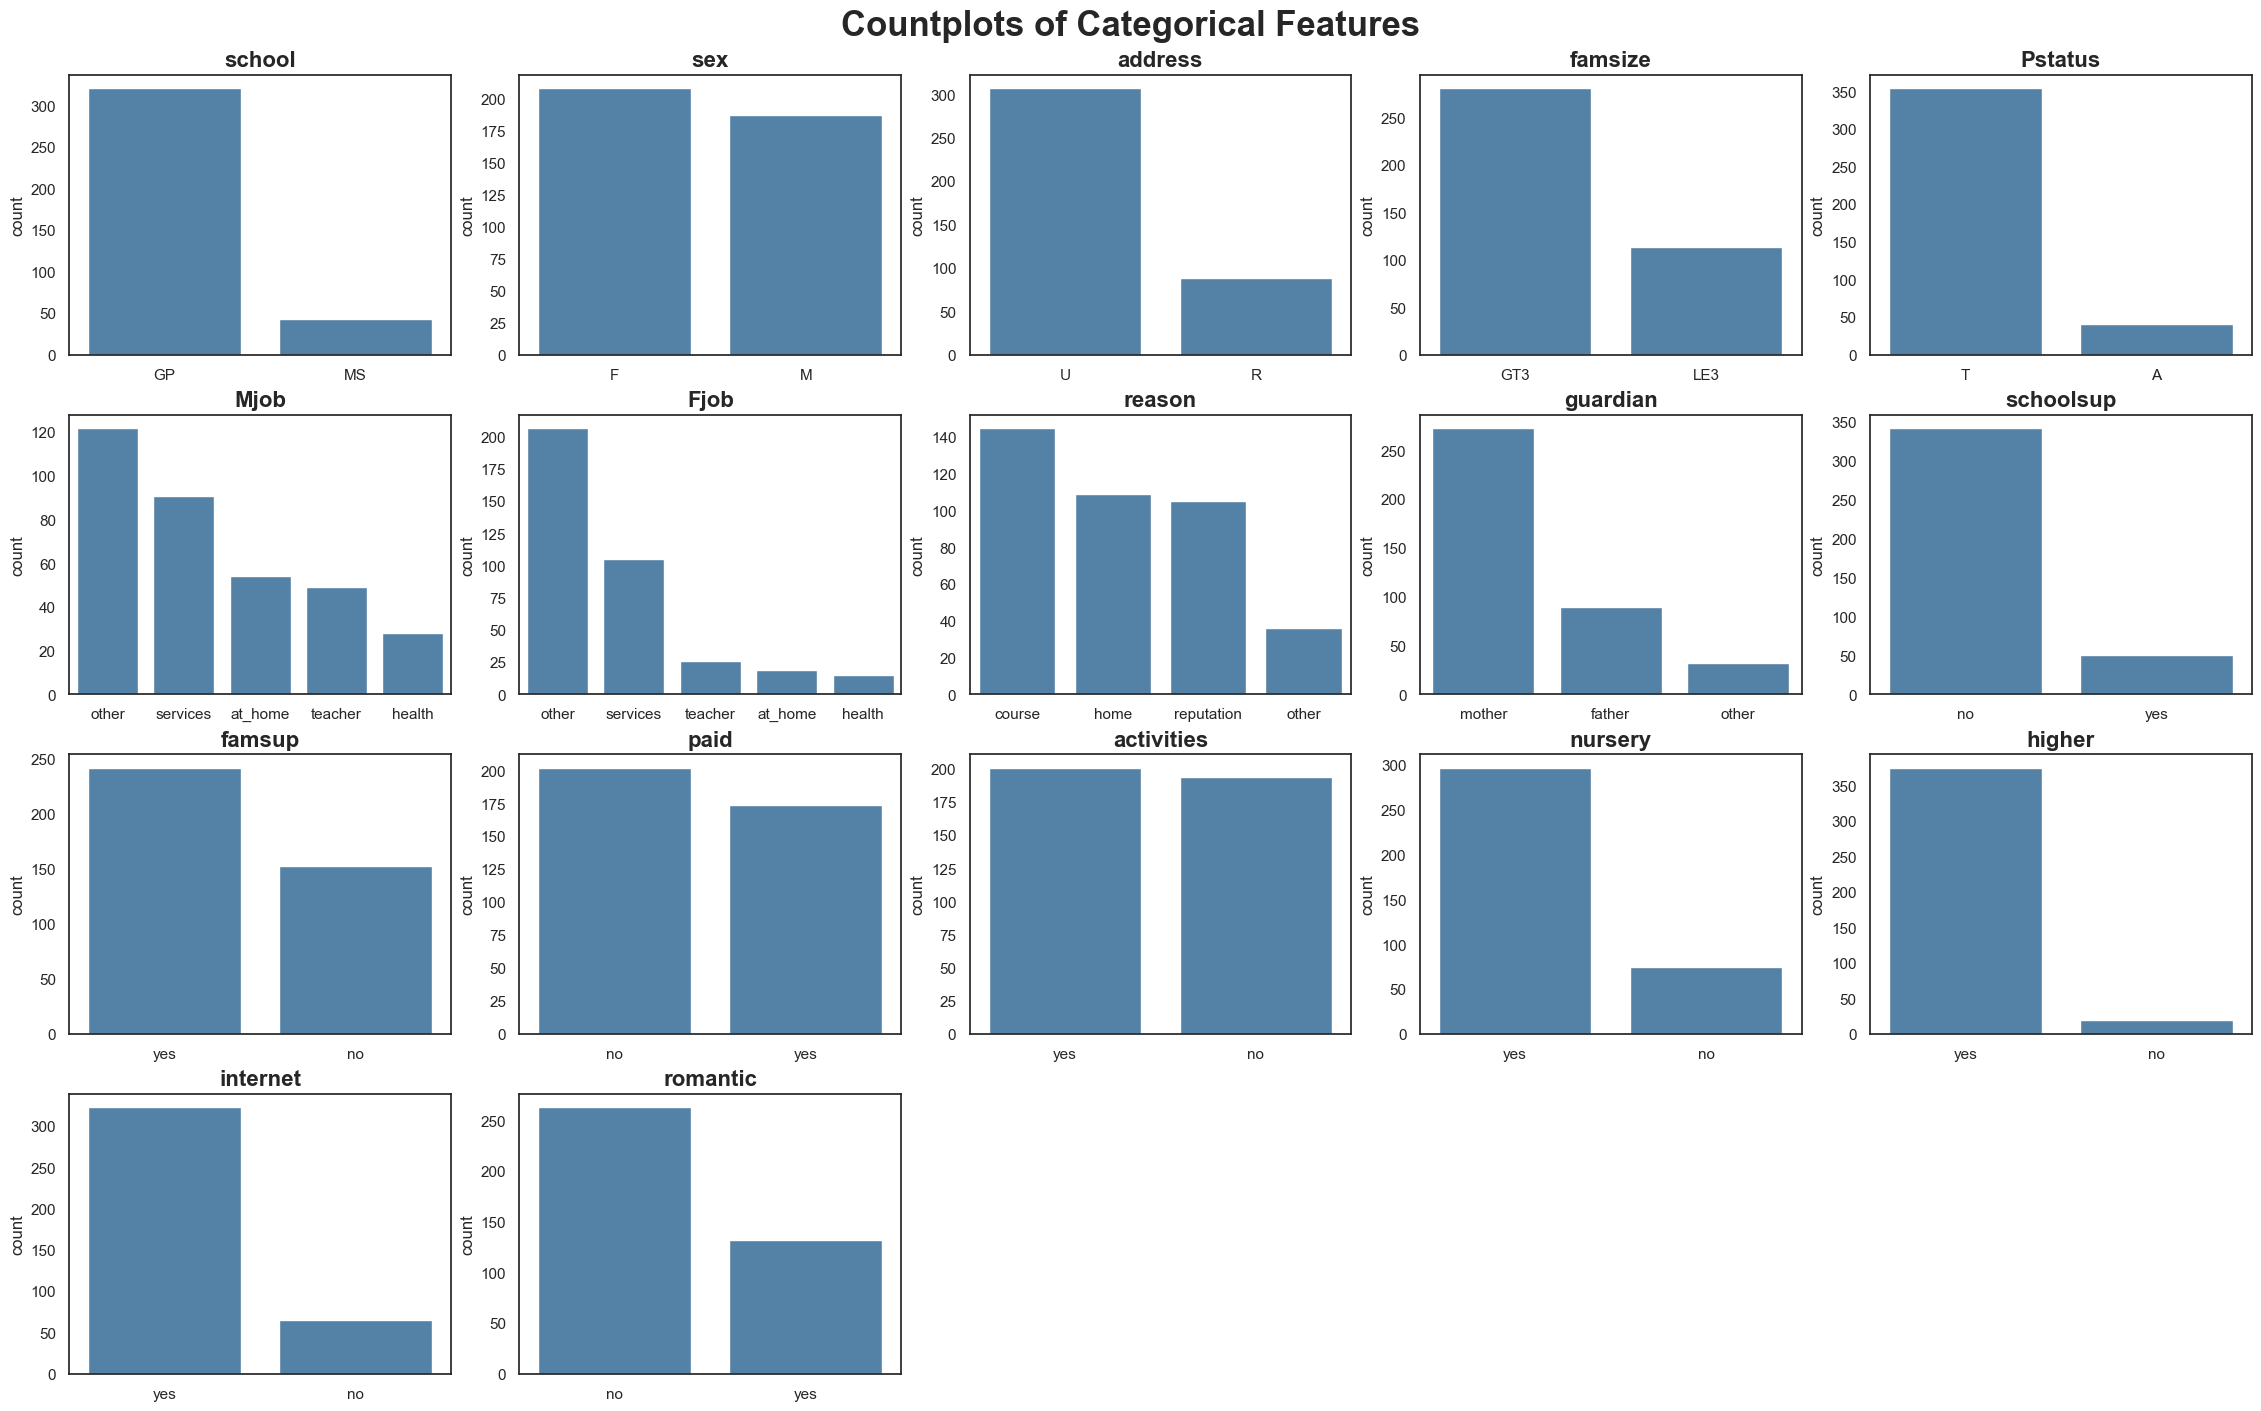

In [43]:
countplots = plot_countplots(df, cat_cols)

- Most categorical features are binary (e.g., `sex`, `romantic`, `famsup`), while a few such as `Mjob`, `Fjob`, and `reason` are multiclass with moderate cardinality. 

- Several features exhibit strong class imbalance—for example, `school`, `address`, `guardian`, and `higher` are dominated by a single category.

- Apparent third categories in features like `schoolsup`, `internet`, and `paid` likely stem from missing values being interpreted as valid categories rather than `NaN`. These issues will be handled during preprocessing.

These insights will inform label cleaning, encoding strategies, and class balancing considerations during modeling. We now proceed to the preprocessing stage to address missing values, encode features, and prepare the data for modeling.


## Saving
---

In [44]:
# Save all EDA plots
save_plot(missing_value_heatmap, "missing_value_heatmap")
save_plot(correlation_matrix, "correlation_matrix")
save_plot(boxplots, "boxplots_numerical_features")
save_plot(feature_distributions, "histograms_numerical_features")
save_plot(countplots, "countplots_categorical_features")

# Save the missing value summary report
save_dataset(missing_report, "missing_report.csv")

Plot saved to: /Users/titanyanlev/student-performance-ml-1/outputs/plots/missing_value_heatmap.png
Plot saved to: /Users/titanyanlev/student-performance-ml-1/outputs/plots/correlation_matrix.png
Plot saved to: /Users/titanyanlev/student-performance-ml-1/outputs/plots/boxplots_numerical_features.png
Plot saved to: /Users/titanyanlev/student-performance-ml-1/outputs/plots/histograms_numerical_features.png
Plot saved to: /Users/titanyanlev/student-performance-ml-1/outputs/plots/countplots_categorical_features.png
Dataset saved to: /Users/titanyanlev/student-performance-ml-1/outputs/reports/missing_report.csv
